<a href="https://colab.research.google.com/gist/poacosta/65a0ec1e4d4144b275d0bc4799c20716/titanic-machine-learning-from-disaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic - Machine Learning from Disaster (0.78468)

* Challenge: https://www.kaggle.com/competitions/titanic/overview

In [31]:
#@title ### Import libraries

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [32]:
#@title ### Feature Engineering

def engineer_features(df):
    # Extract titles from names
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major',
                                     'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')

    # Create family size feature
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

    # Create is_alone feature
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

    # Bin age
    df['AgeBand'] = pd.cut(df['Age'].fillna(df['Age'].mean()),
                          bins=[0, 16, 32, 48, 64, np.inf],
                          labels=['Child', 'Young', 'Adult', 'MiddleAge', 'Senior'])

    # Bin fare
    df['FareBand'] = pd.qcut(df['Fare'].fillna(-1), 4, labels=['Low', 'Mid', 'High', 'VeryHigh'])

    return df

In [33]:
#@title ### Data Preprocessing

def preprocess_data(df):
    # Drop unnecessary columns
    drop_cols = ['Name', 'Ticket', 'Cabin', 'PassengerId']
    df = df.drop(drop_cols, axis=1)

    # Convert categorical variables
    categorical_cols = ['Sex', 'Title', 'Embarked', 'AgeBand', 'FareBand']
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

    return df

In [34]:
#@title ### Model Training

def train_model(X_train, y_train):
    rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
    rf.fit(X_train, y_train)
    return rf

In [35]:
#@title ### Feature Importance Plot

def plot_feature_importance(model, feature_names):
    importance = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance.head(10), x='importance', y='feature')
    plt.title('Top 10 Most Important Features')
    plt.tight_layout()
    plt.show()


Validation Metrics:
              precision    recall  f1-score   support

           0       0.83      0.88      0.85       105
           1       0.81      0.74      0.77        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179


Cross-validation scores: [0.83798883 0.81460674 0.8258427  0.79775281 0.83146067]
Average CV score: 0.822 (+/- 0.028)


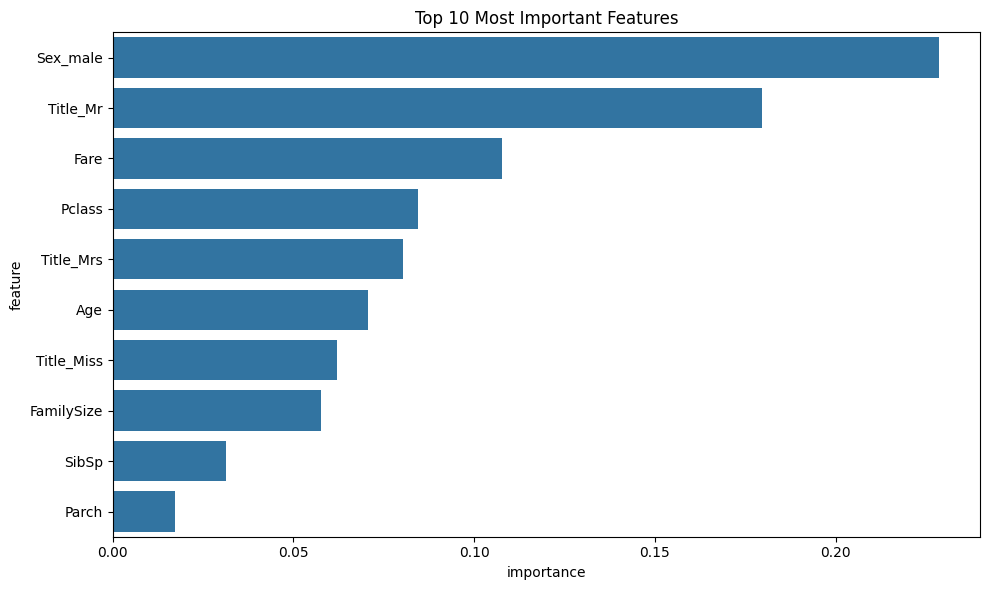

In [36]:
#@title ### Pipeline

# Load data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Feature engineering
train_data = engineer_features(train_data)
test_data = engineer_features(test_data)

# Preprocess data
X = preprocess_data(train_data.drop('Survived', axis=1))
y = train_data['Survived']

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = train_model(X_train, y_train)

# Evaluate model
val_pred = model.predict(X_val)
print("\nValidation Metrics:")
print(classification_report(y_val, val_pred))

# Cross-validation
cv_scores = cross_val_score(model, X, y, cv=5)
print(f"\nCross-validation scores: {cv_scores}")
print(f"Average CV score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

# Feature importance
plot_feature_importance(model, X.columns)

# Prepare submission
test_processed = preprocess_data(test_data)
submission_pred = model.predict(test_processed)
submission = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],
    'Survived': submission_pred
})
submission.to_csv('submission.csv', index=False)